# Singapore Resale Flat Prices Per Square Metre

Instead of predicting the resale flat price per apartment, predict the resale flat price per square metre.

The data used in this project is available from: https://data.gov.sg/dataset/resale-flat-prices.

In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from resale.adjust_price import adjust_resale_price_per_town
from resale.clean_data import clean_data, sqm_to_sqft
from resale.geocode import load_geocoded_addresses_json
from resale.load_data import load_data, from_year
from resale.h3_geocode import latlon_to_h3
from resale.h3_statistics import kring_smoothing
from resale.inference_data import make_inference_data
from resale.model import make_Xy, y_descaler
from resale.statistics import get_monthly_median_price

Geocoded addresses: 9523.


In [50]:
# Load and clean data.
df = load_data(online = False)
df = clean_data(df)

# Restrict the data to past 2015...
df = from_year(df, 2015)

# Add h3 cell indices.
df = latlon_to_h3(df, 8)

# Calculate the resale price adjustments...
df, temporal_models = adjust_resale_price_per_town(df, price_column = "price_per_sqm", vander_order = 4,
                                                   model = "least_squares", which = "h3")
df = df.sort_values(["town", "block"])

display(df[["year", "address", "floor_area_sqm", "resale_price", "price_per_sqm", "price_per_sqm_adj"]].head())

Loading data from disk...
Downloaded data shape: (868879, 10).
Geocoded addresses: 9523.


,year,address,floor_area_sqm,resale_price,price_per_sqm,price_per_sqm_adj
118964,2017,101 ANG MO KIO AVENUE 3,117.0,500000.0,4273,4680
119086,2018,101 ANG MO KIO AVENUE 3,117.0,552000.0,4717,5409
119206,2018,101 ANG MO KIO AVENUE 3,117.0,528000.0,4512,5359
119216,2019,101 ANG MO KIO AVENUE 3,117.0,564000.0,4820,5745
119307,2019,101 ANG MO KIO AVENUE 3,117.0,506888.0,4332,5262


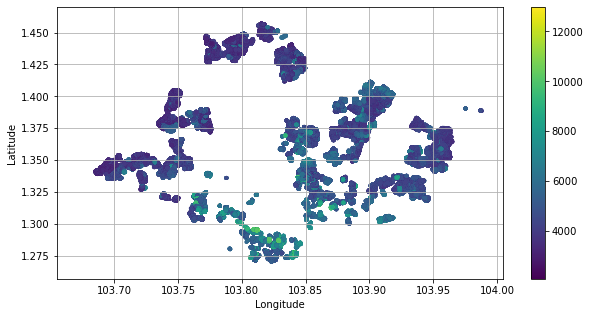

In [51]:
def geoplot(df, c = "price_per_sqm"):
    plt.figure(figsize = (10, 5))
    plt.scatter(df["longitude"], df["latitude"], c = df[c], marker = ".", cmap = "viridis")
    plt.axis("equal")
    plt.grid(True)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim([103.63, 104.03])
    plt.ylim([1.257, 1.47])
    plt.colorbar()
    plt.show()
    
geoplot(df, "price_per_sqm")

In [52]:
X, y = make_Xy(df, scale_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

model = LGBMRegressor(n_estimators = 500, max_depth = 10, random_state = 42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train score: {:.2f}, test score: {:.2f}.".format(model.score(X_train, y_train), 
                                                        model.score(X_test, y_test)))

Train score: 0.90, test score: 0.89.


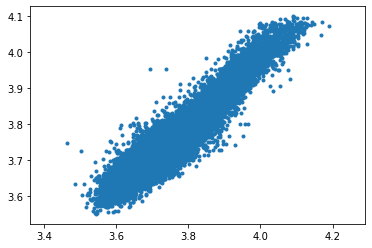

In [53]:
plt.plot(y_test, y_test_pred, ".")
plt.axis("equal")
plt.show()

In [54]:
inf_dat = {"address": "101 ANG MO KIO AVENUE 3", 
           "flat_type": "5 ROOM", 
           "storey_range": "01 TO 03", 
           "age": 44}

inf_dat = make_inference_data(**inf_dat)

inf_pred = y_descaler(model.predict(inf_dat)).astype(int)[0]

print("Predicted price-per-sqm: {}.".format(inf_pred))

Predicted price-per-sqm: 4870.


In [64]:
df[df["year_month"] == pd.to_datetime("2022-03-01")]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,floor_area_norm,age,latitude,longitude,lat,lon,h3,adj_months,adj_factor,price_per_sqm_adj
119637,2022-03,ANG MO KIO,4 ROOM,102,ANG MO KIO AVE 3,07 TO 09,106.0,MODEL A,1993,580000.0,...,0.555922,29,1.370650,103.839410,0.537092,0.509564,88652636c1fffff,87,1.0,5471
119639,2022-03,ANG MO KIO,4 ROOM,102,ANG MO KIO AVE 3,10 TO 12,106.0,MODEL A,1993,666666.0,...,0.555922,29,1.370650,103.839410,0.537092,0.509564,88652636c1fffff,87,1.0,6289
121205,2022-03,ANG MO KIO,3 ROOM,106,ANG MO KIO AVE 4,07 TO 09,74.0,NEW GENERATION,1978,350888.0,...,0.405848,44,1.371934,103.837486,0.543967,0.503204,88652636c7fffff,87,1.0,4741
119632,2022-03,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,NEW GENERATION,1978,325888.0,...,0.364350,44,1.370097,103.837688,0.534127,0.503871,88652636c1fffff,87,1.0,4864
121207,2022-03,ANG MO KIO,3 ROOM,112,ANG MO KIO AVE 4,07 TO 09,74.0,NEW GENERATION,1978,370000.0,...,0.405848,44,1.371279,103.835767,0.540459,0.497522,88652636c7fffff,87,1.0,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118782,2022-03,YISHUN,EXECUTIVE,824,YISHUN ST 81,01 TO 03,142.0,APARTMENT,1987,800000.0,...,0.678023,35,1.413745,103.833303,0.767928,0.489380,88652636a5fffff,87,1.0,5633
118783,2022-03,YISHUN,EXECUTIVE,828,YISHUN ST 81,01 TO 03,142.0,APARTMENT,1988,723000.0,...,0.678023,34,1.415191,103.832902,0.775671,0.488053,88652636a5fffff,87,1.0,5091
118781,2022-03,YISHUN,5 ROOM,851,YISHUN ST 81,10 TO 12,122.0,IMPROVED,1988,595000.0,...,0.614629,34,1.415588,103.836811,0.777797,0.500972,88652636a5fffff,87,1.0,4877
118784,2022-03,YISHUN,EXECUTIVE,877,YISHUN ST 81,10 TO 12,145.0,MAISONETTE,1987,818000.0,...,0.686753,35,1.413902,103.835454,0.768768,0.496488,88652636a5fffff,87,1.0,5641
